<h1>Машинне навчання</h1>
<p>Ю.С. Процик. Курс лекцій</p>
<div align="right"><em>Cформовано на основі <a href="https://mlcourse.ai">відкритого курсу</a> Юрія Кашницького</em></div>

# <center>Тема 9. Навчання на гігабайтах даних з Vowpal Wabbit</center>

## План
1. [Стохастичний градієнтний спуск і онлайн-підхід до навчання](#1.-Стохастичний-градієнтний-спуск-і-онлайн\-підхід-до-навчання)
    - [Стохастичний градієнтний спуск](#Стохастичний-градієнтний-спуск)
    - [Онлайн-підхід до навчання](#Онлайн\-підхід-до-навчання)
2. [Робота з категоріальними ознаками: Label Encoding, One-Hot Encoding, Hashing trick](#2.-Робота-з-категоріальними-ознаками:-Label-Encoding,-One\-Hot-Encoding,-Hashing-trick)
    - [Label Encoding](#Label-Encoding)
    - [One-Hot Encoding](#One\-Hot-Encoding)
    - [Хешування ознак (Hashing trick)](#Хешування-ознак-\(Hashing-trick\))
3. Vowpal Wabbit
    - Новини. Бінарна класифікація
    - Листи. Багатокласова класифікація
    - Рецензії до фільмів IMDB
    - Класифікація запитань на Stackoverflow

Ось ми поступово і дійшли до просунутих методів машинного навчання, сьогодні обговоримо, як взагалі підступитися до навчання моделі, якщо даних гігабайти і десятки гігабайт.
Обговоримо прийоми, що дозволяють це робити: стохастичний градієнтний спуск (SGD) і хешування ознак, подивимося на приклади застосування бібліотеки Vowpal Wabbit.

Спочатку імпортуємо відразу всі потрібні бібліотеки

In [1]:
import warnings
import os
import re
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
warnings.filterwarnings('ignore')

## 1. Стохастичний градієнтний спуск і онлайн-підхід до навчання

### Стохастичний градієнтний спуск

Незважаючи на те, що градієнтний спуск – одна з перших тем, що вивчаються в теорії оптимізації і машинному навчанні, складно переоцінити важливість однієї його модифікації – стохастичного градієнтного спуску, який ми часто будемо називати просто SGD (Stochastic Gradient Descent).

Нагадаємо, що суть градієнтного спуску – мінімізувати функцію, роблячи невеликі кроки в напрямку найшвидшого спадання функції. Назву методу подарував той факт з математичного аналізу, що вектор $\large\nabla f = \left(\frac{\partial f}{\partial x_1}, \ldots, \frac{\partial f}{\partial x_n}\right)^T$ часткових похідних функції $f(x) = f(x_1, \ldots, x_n)$ задає напрямок найшвидшого зростання цієї функції. Значить, рухаючись в напрямку антиградієнта функції (вектора, протилежного градієнту), можна зменшувати її значення швидше за все.

Ідея градієнтного спуску: якщо задача – якомога швидше спуститися з гори на сноуборді, то потрібно в кожній точці вибирати максимальний нахил (якщо це сумісно з життям), тобто обчислювати антиградієнт.

**Приклад**

Задачу простої парної регресії можна розв'язувати за допомогою градієнтного спуску. Спрогнозуємо одну змінну за іншою – зріст за вагою, припускаючи, що ці змінні лінійно залежні. Будемо використовувати набір даних [SOCR](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data).

In [3]:
PATH_TO_ALL_DATA = '../data/'
data_demo = pd.read_csv(os.path.join(PATH_TO_ALL_DATA,
                                     'weights_heights.csv'))

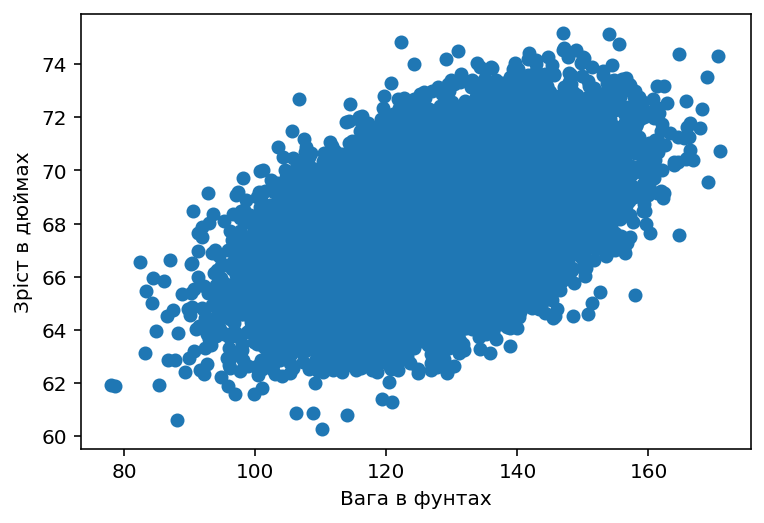

In [4]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вага в фунтах')
plt.ylabel('Зріст в дюймах');

Дано вектор $x$ довжини $\ell$ – значення ваги для кожного спостереження (людини) і $y$ – вектор значень зросту для кожного спостереження (людини).

Задача: знайти такі ваги $w_0$ і $w_1$, щоб при прогнозуванні зросту за вагою у вигляді $y_i = w_0 + w_1 x_i$ (де $y_i$ – $i$-е значення зросту, $x_i$ – $i$-е значення ваги) мінімізувати квадратичну помилку (можна і середньоквадратичну, але константа $\displaystyle\frac{1}{\ell}$ погоди не робить, а $\displaystyle\frac{1}{2}$ заведена для краси):
$$ \large
SE(w_0, w_1) = \frac{1}{2}\sum_{i=1}^\ell(y_i - (w_0 + w_1x_{i}))^2 \rightarrow \min\limits_{w_0,w_1}
$$

Робити ми це будемо з допомогою градієнтного спуску, порахувавши часткові похідні функції $SE(w_0, w_1)$ по вагам в моделі – $w_0$ і $w_1$.
Ітеративна процедура навчання буде задаватися простими формулами оновлення ваг (міняємо ваги так, щоб робити невеликий, пропорційно малій константі $\eta$, крок в напрямку антиградієнта функції):

$$\large
\begin{array}{rcl}\displaystyle 
w_0^{(t+1)} = w_0^{(t)} -\left. \eta \frac{\partial SE}{\partial w_0}\right|_{t} \\\displaystyle  
w_1^{(t+1)} = w_1^{(t)} -\left. \eta \frac{\partial SE}{\partial w_1}\right|_{t} 
\end{array}
$$

Якщо обчислити часткові похідні, то отримаємо

$$\large
\begin{array}{rcl}\displaystyle  
w_0^{(t+1)} = w_0^{(t)} + \eta \sum\limits_{i=1}^{\ell}(y_i - w_0^{(t)} - w_1^{(t)}x_i) \\\displaystyle  
w_1^{(t+1)} = w_1^{(t)} + \eta \sum\limits_{i=1}^{\ell}(y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i 
\end{array}
$$

І все це досить добре працює (в цій темі ми не будемо обговорювати проблеми локальних мінімумів, підбору кроку градієнтного спуску і т.д. – про це і так багато написано, можна звернутися до [розділу](http://www.deeplearningbook.org/contents/numerical.html) "Numeric Computation" книги "Deep Learning") поки даних не стає занадто багато. Проблема такого підходу в тому, що обчислення градієнта зводиться до сумування деяких величин для кожного об'єкта навчальної вибірки. Проблема в тому, що ітерацій алгоритму на практиці потрібно багато, а на кожній ітерації ваги перераховуються за формулою, в якій є сума по всій вибірці виду $\displaystyle\sum\limits_{i=1}^\ell$. А що якщо об'єктів у вибірці мільйони і мільярди?

Суть стохастичного градієнтного спуску – неформально, викинути знак суми з формул перерахунку ваг і оновлювати їх по одному об'єкту (або невеликій кількості). Тобто в нашому випадку

$$\large
\begin{array}{rcl}\displaystyle  
w_0^{(t+1)} = w_0^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i) \\\displaystyle  
w_1^{(t+1)} = w_1^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i 
\end{array}
$$

При такому підході на кожній ітерації вже зовсім не гарантований рух в напрямку найшвидшого спадання функції, і ітерацій може знадобитися на кілька порядків більше, ніж при звичайному градієнтному спуску. Зате перерахунок ваг на кожній ітерації робиться майже миттєво.

В якості ілюстрації візьмемо рисунок Ендрю Ина з його [курсу](https://www.coursera.org/learn/machine-learning) машинного навчання.

<img src='../img/sgd_convergence.png'>

На рисунку відображені лінії рівня деякою функції, мінімум якої ми шукаємо. Червона крива показує зміну ваг (на рисунку $\theta_0$ і $\theta_1$ відповідають $w_0$ і $w_1$ в нашому прикладі). За властивостями градієнта напрямок зміни в кожній точці буде перпендикулярний лініям рівня. При стохастичному підході на кожній ітерації ваги змінюються менш передбачувано, інколи навіть здається, що деякі кроки невдалі – відводять від шуканого мінімуму, але в результаті обидві процедури збігаються приблизно до одного розв'язку.

Збіжність стохастичного градієнтного спуску до того ж розв'язку, що і у градієнтного спуску, є одним з найважливіших фактів, доведених в теорії оптимізації. Зараз в епоху Big Data і Deep Learning частіше саме стохастичну версію називають градієнтним спуском.

### Онлайн-підхід до навчання

Стохастичний градієнтний спуск, будучи одним з методів оптимізації, дає цілком практичні рекомендації до навчання алгоритмів класифікації і регресії на великих вибірках – до сотень гігабайт (в залежності від наявної пам'яті).

У разі парної регресії, який ми розглянули, на диску можна зберігати навчальну вибірку $(X,y)$ і, не завантажуючи її в оперативну пам'ять (вона може просто не поміститися), зчитувати об'єкти по одному та оновлювати ваги:

$$\large
\begin{array}{rcl}\displaystyle  
w_0^{(t+1)} = w_0^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i) \\\displaystyle  
w_1^{(t+1)} = w_1^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i 
\end{array}
$$

Після обробки всіх об'єктів навчальної вибірки, функціонал, який ми оптимізуємо (квадратична помилка в задачі регресії або, наприклад, логістична – в задачі класифікації) зменшиться, але часто потрібно кілька десятків проходів по вибірці, щоб досягнути достатнього результату зменшення.

Такий підхід до навчання моделей часто називають *онлайн-навчанням*.

В цій лекції ми не розглядаємо багатьох нюансів стохастичної оптимізації. Фундаментально вивчити цю тему можна по книзі [Stephen Boyd "Convex Optimization"](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf). Перейдемо швидше до бібліотеки Vowpal Wabbit, за допомогою якої можна навчати прості моделі на величезних вибірках за рахунок стохастичної оптимізації і ще одного трюку – хешування ознак, про який піде мова далі.

В библиотеке Scikit-learn классификаторы и регрессоры, обучаемые стохастическим градиентным спуском, реализованы классами `SGDClassifier` и `SGDRegressor` из `sklearn.linear_model`. Частью домашнего задания будет разобраться в них уже после собственной реализации этих простых онлайн-алгоритмов.

У бібліотеці Scikit-learn класифікатори та регресори, які навчають стохастичним градієнтним спуском, реалізовані класами `SGDClassifier` і` SGDRegressor` з `sklearn.linear_model`.

## 2. Робота з категоріальними ознаками: Label Encoding, One-Hot Encoding, Hashing trick

### Label Encoding
Переважна більшість методів класифікації і регресії сформульовані в термінах евклідових або метричних просторів, тобто передбачають подання даних у вигляді дійснозначних векторів однакової розмірності. Однак, в реальних даних часто зустрічаються категоріальні ознаки, які приймають дискретні значення, такі як так/ні або січень/лютий/.../грудень. Обговоримо те, як працювати з такими даними, зокрема за допомогою лінійних моделей, і що робити, якщо категоріальних ознак багато, та ще й у кожної купа унікальних значень.

Розглянемо вибірку [UCI bank](https://archive.ics.uci.edu/ml/datasets/bank+marketing), в якій велика частина ознак – категоріальні.

In [5]:
df = pd.read_csv(os.path.join(PATH_TO_ALL_DATA, 'UCI_bank/bank_train.csv'))
labels = pd.read_csv(os.path.join(PATH_TO_ALL_DATA,
                                  'UCI_bank/bank_train_target.csv'), 
                     header=None)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,high.school,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,university.degree,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,basic.4y,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,university.degree,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,university.degree,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


Неважко помітити, що досить багато ознак в цьому наборі даних не представлені числами. У такому вигляді дані ще нам не підходять – ми не зможемо застосовувати переважну більшість доступних методів.

Щоб знайти рішення, давайте розглянемо ознаку "education":

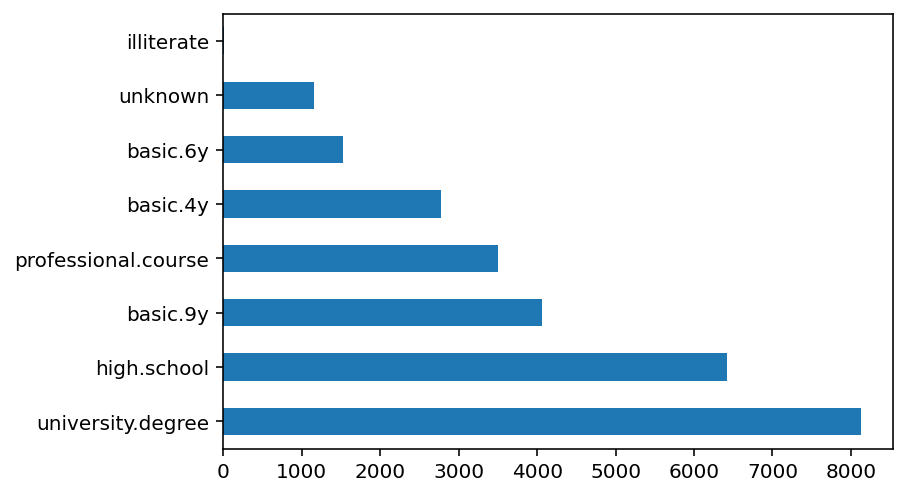

In [6]:
df['education'].value_counts().plot.barh();

Природним рішенням такої проблеми було б однозначне відображення кожного значення в унікальне число. Наприклад, ми могли б перетворити `university.degree` в 0, а `basic.9y` в 1. Цю просту операцію доводиться робити часто, тому в модулі `preprocessing` бібліотеки `sklearn` саме для цієї задачі реалізований клас `LabelEncoder`:

In [7]:
label_encoder = LabelEncoder()

Метод `fit` цього класу знаходить все унікальні значення і будує таблицю для відповідності кожної категорії деякому числа, а метод `transform` безпосередньо перетворює значення в числа. Після `fit` у `label_encoder` буде доступне поле `classes_`, що містить всі унікальні значення. Пронумеруємо їх, щоб переконатися, що перетворення виконано вірно.

{0: 'basic.4y', 1: 'basic.6y', 2: 'basic.9y', 3: 'high.school', 4: 'illiterate', 5: 'professional.course', 6: 'university.degree', 7: 'unknown'}


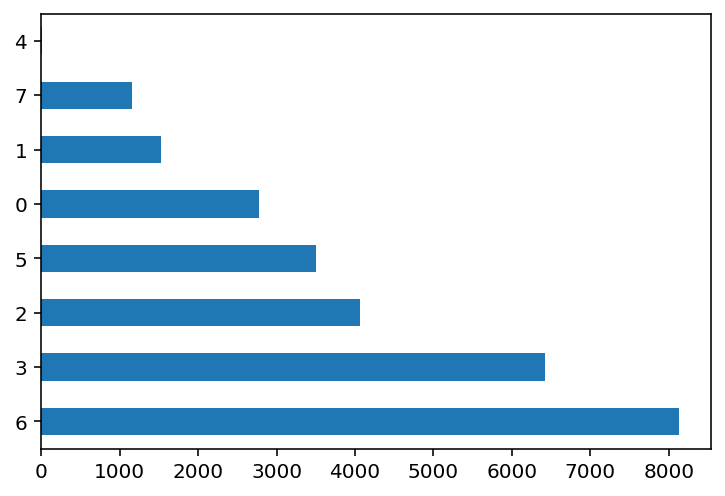

In [8]:
mapped_education = pd.Series(label_encoder.fit_transform(df['education']))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

Що станеться, якщо у нас з'являться дані з іншими категоріями?

In [9]:
try:
    label_encoder.transform(df['education'].replace('high.school', 'high_school'))
except Exception as e:
    print('Error:', e)

Error: y contains previously unseen labels: 'high_school'


Таким чином, при використанні цього підходу ми завжди повинні бути впевнені, що ознака не може приймати невідомих раніше значень. До цієї проблеми ми повернемося трохи пізніше, а зараз замінимо весь стовпець "education" на перетворений:

In [10]:
df['education'] = mapped_education
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,3,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,6,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,0,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,6,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,6,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


Продовжимо перетворення для всіх стовпців, що мають тип `object` – саме цей тип задається в pandas для таких даних.

In [11]:
df.columns[df.dtypes == 'object'].union(['education'])

Index(['contact', 'day_of_week', 'default', 'education', 'housing', 'job',
       'loan', 'marital', 'month', 'poutcome'],
      dtype='object')

In [12]:
categorical_columns = df.columns[df.dtypes == 'object'].union(['education'])
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,8,2,3,0,0,0,1,4,1,901,1,999,0,1,1.4,94.465,-41.8,4.961,5228.1
1,46,0,1,6,0,2,0,0,1,3,208,2,999,0,1,1.4,93.444,-36.1,4.963,5228.1
2,49,1,1,0,1,2,2,1,4,3,131,5,999,0,1,1.4,94.465,-41.8,4.864,5228.1
3,31,9,1,6,0,0,0,0,3,3,404,1,999,0,1,-2.9,92.469,-33.6,1.044,5076.2
4,42,3,1,6,0,2,0,1,7,1,85,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8


Основна проблема такого подання полягає в тому, що числовий код створив евклідове представлення для даних.

Наприклад, нами неявним чином була введена алгебра над значеннями роботи – ми можемо відняти роботу клієнта 1 від роботи клієнта 2:

In [13]:
df.loc[1].job - df.loc[2].job

-1.0

Звичайно ж, ця операція не має ніякого сенсу. Але саме на цьому базуються метрики близькості об'єктів, що робить безглуздим застосування методу найближчого сусіда на даних в такому вигляді. Аналогічним чином, ніякого сенсу не матиме застосування лінійних моделей. Переконаємося в цьому:

In [14]:
def logistic_regression_accuracy_on(dataframe, labels):
    features = dataframe.to_numpy()
    train_features, test_features, train_labels, test_labels = \
        train_test_split(features, labels)

    logit = LogisticRegression()
    logit.fit(train_features, train_labels)
    return classification_report(test_labels, logit.predict(test_features))

print(logistic_regression_accuracy_on(df[categorical_columns], labels))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6105
           1       0.80      0.01      0.01       794

    accuracy                           0.89      6899
   macro avg       0.84      0.50      0.47      6899
weighted avg       0.88      0.89      0.83      6899



Для того, щоб ми змогли застосовувати лінійні моделі на таких даних нам необхідний інший метод, який називається One-Hot Encoding

### One-Hot Encoding

Припустимо, що деяка ознака може приймати 10 різних значень. В цьому випадку one-hot encoding має на увазі створення 10 ознак, всі з яких дорівнюють нулю *за винятком однієї*. На позицію, що відповідає числовому значенню ознаки ми ставимо 1:

In [15]:
one_hot_example = pd.DataFrame([{i: 0 for i in range(10)}])
one_hot_example.loc[0, 6] = 1
one_hot_example

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0


Ця техніка реалізована в `sklearn.preprocessing` в класі `OneHotEncoder`. За замовчуванням `OneHotEncoder` перетворює дані в розріджену матрицю, щоб не витрачати пам'ять на зберігання численних нулів. Однак в цьому прикладі розмір даних не є для нас проблемою, тому ми будемо використовувати "щільне" представлення.

In [16]:
onehot_encoder = OneHotEncoder(sparse=False)

In [17]:
encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(df[categorical_columns]))
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Ми отримали 53 стовпці – саме стільки різних унікальних значень можуть приймати категоріальні стовпці вихідної вибірки. Перетворені за допомогою One-Hot Encoding дані починають набувати змісту для лінійної моделі:

In [18]:
print(logistic_regression_accuracy_on(encoded_categorical_columns, labels))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      6081
           1       0.68      0.18      0.29       818

    accuracy                           0.89      6899
   macro avg       0.79      0.59      0.62      6899
weighted avg       0.87      0.89      0.86      6899



### Хешування ознак (Hashing trick)

Реальні дані можуть виявитися набагато динамічнішими, і ми не завжди можемо розраховувати, що категоріальні ознаки не прийматимуть нових значень. Все це сильно ускладнює використання вже навчених моделей на нових даних. Крім того, `LabelEncoder` передбачає попередній аналіз всієї вибірки і зберігання побудованих відображень в пам'яті, що ускладнює роботу в режимі великих даних.

Для вирішення цих проблем існує більш простий підхід до векторизації категоріальних ознак, що базується на хешуванні, і відомий як hashing trick.

Хеш-функції можуть допомогти нам в задачі пошуку унікальних кодів для різних значень ознаки, наприклад:

In [19]:
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '->', hash(s))

university.degree -> -25360769126844041
high.school -> 6901360498827152137
illiterate -> -1867406887552627762


Від'ємні і настільки великі за модулем значення нам не підійдуть. Обмежимо область значень хеш-функції:

In [20]:
hash_space = 25
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '->', hash(s) % hash_space)

university.degree -> 9
high.school -> 12
illiterate -> 13


Уявімо, що у нас в вибірці є неодружений студент, якому подзвонили в понеділок, тоді його вектор ознак буде сформований аналогічно One-Hot Encoding, але в єдиному просторі фіксованого розміру для всіх ознак:

In [21]:
hashing_example = pd.DataFrame([{i: 0.0 for i in range(hash_space)}])
for s in ('job=student', 'marital=single', 'day_of_week=mon'):
    print(s, '->', hash(s) % hash_space)
    hashing_example.loc[0, hash(s) % hash_space] = 1
hashing_example

job=student -> 13
marital=single -> 8
day_of_week=mon -> 1


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Варто звернути увагу, що в цьому прикладі хешувалися не тільки значення ознак, а пари **назва ознаки + значення ознаки**. Це необхідно, щоб розділити однакові значення різних ознак між собою, наприклад:

In [22]:
assert hash('no') == hash('no')
assert hash('housing=no') != hash('loan=no')

Чи може статися колізія хеш-функції, тобто співпадіння кодів для двох різних значень? Неважко довести, що при достатньому розмірі простору хешування це відбувається рідко, але навіть в тих випадках, коли таке відбувається, це не буде приводити до істотного погіршення якості класифікації або регресії.

<img src="../img/hashing_trick.jpg">

Можливо, ви запитаєте: "а що взагалі відбувається?", і здасться, що при хешуванні ознак страждає здоровий глузд. Можливо, але ця евристика – по суті, єдиний підхід до того, щоб працювати з категоріальними ознаками, у яких багато унікальних значень. Більше того, ця техніка себе добре зарекомендувала на практиці. Детальніше про хешування ознак (learning to hash) можна почитати в [цьому](https://arxiv.org/abs/1509.05472) огляді, а також в [матеріалах](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture06-linclass.pdf) Євгенія Соколова.